In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read the data
df=pd.read_csv('country_vaccinations.csv')

In [3]:
# print head
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
       country iso_code        date  total_vaccinations  people_vaccinated  \
0  Afghanistan      AFG  2021-02-22                 0.0                0.0   
1  Afghanistan      AFG  2021-02-23                 NaN                NaN   
2  Afghanistan      AFG  2021-02-24                 NaN                NaN   
3  Afghanistan      AFG  2021-02-25                 NaN                NaN   
4  Afghanistan      AFG  2021-02-26                 NaN                NaN   

   people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
0                      NaN                     NaN                 NaN   
1                      NaN                     NaN              1367.0   
2                      NaN                     NaN              1367.0   
3                      NaN                     NaN              1367.0   
4                      NaN                     NaN              1367.0   

   total_vaccinations_per_hundred  people_vaccinated_per_

In [4]:
print(f"Dataset Shape: {df.shape[0]} rows and {df.shape[1]} columns.")
print("\nData Types of Columns:")
print(df.dtypes)
print("-" * 50)

Dataset Shape: 86512 rows and 15 columns.

Data Types of Columns:
country                                 object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
daily_vaccinations_per_million         float64
vaccines                                object
source_name                             object
source_website                          object
dtype: object
--------------------------------------------------


In [5]:
# Convert 'date' to datetime (coerce invalid values to NaT)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [6]:
# Report missing values before cleaning
print("Missing values per column before cleaning:")
print(df.isnull().sum())

Missing values per column before cleaning:
country                                    0
iso_code                                   0
date                                       0
total_vaccinations                     42905
people_vaccinated                      45218
people_fully_vaccinated                47710
daily_vaccinations_raw                 51150
daily_vaccinations                       299
total_vaccinations_per_hundred         42905
people_vaccinated_per_hundred          45218
people_fully_vaccinated_per_hundred    47710
daily_vaccinations_per_million           299
vaccines                                   0
source_name                                0
source_website                             0
dtype: int64


In [7]:
# Fill daily_vaccinations with median per country; if a country has all NaN, use 0
def _fill_country_median(s: pd.Series) -> pd.Series:
    med = s.median()
    return s.fillna(0 if pd.isna(med) else med)

In [8]:
df["daily_vaccinations"] = (
    df.groupby("country")["daily_vaccinations"]
      .transform(_fill_country_median)
)


In [9]:
print("\nMissing values in 'daily_vaccinations' after cleaning:",
      df["daily_vaccinations"].isnull().sum())
print("-" * 50)


Missing values in 'daily_vaccinations' after cleaning: 0
--------------------------------------------------


In [10]:
# Sort for time operations
df = df.sort_values(["country", "date"]).reset_index(drop=True)

In [11]:

# Latest row per country (used multiple times)
latest = df.loc[df.groupby("country")["date"].idxmax()].copy()

In [12]:
# 4) Top 5 by people_fully_vaccinated (latest date for each country)
top5_fully = (
    latest[["country", "people_fully_vaccinated"]]
    .sort_values("people_fully_vaccinated", ascending=False)
    .head(5)
    .reset_index(drop=True)
)
print("Top 5 countries by people_fully_vaccinated (latest date):")
print(top5_fully)
print("-" * 50)

Top 5 countries by people_fully_vaccinated (latest date):
         country  people_fully_vaccinated
0          India              828229455.0
1  United States              217498967.0
2         Brazil              160272858.0
3      Indonesia              158830466.0
4     Bangladesh              107712737.0
--------------------------------------------------


Saved: india_total_vaccinations_trend.png
--------------------------------------------------


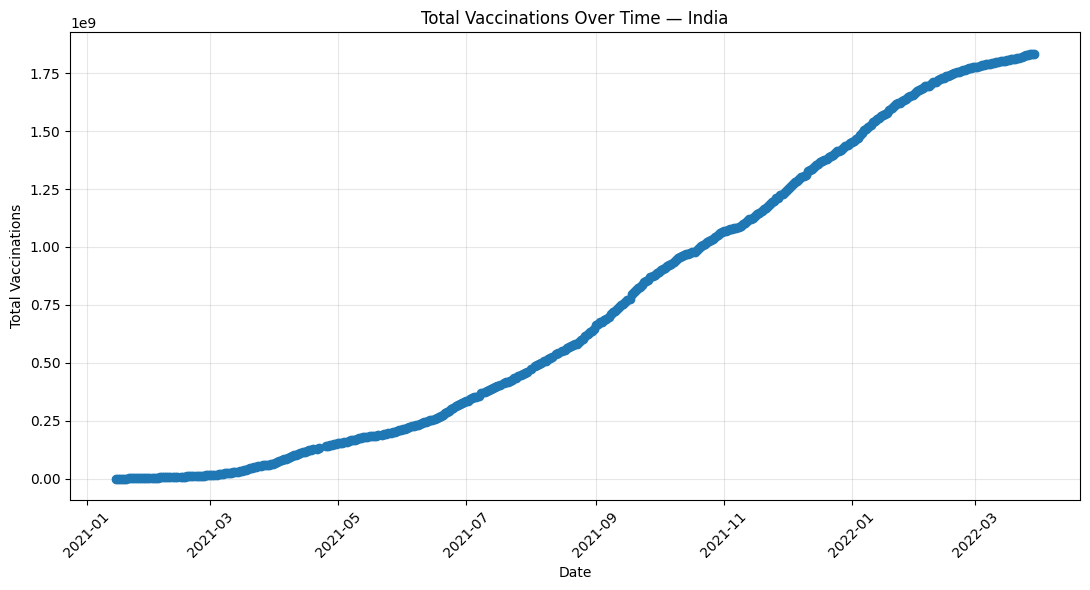

In [13]:
# 5) India trend — total_vaccinations over time (line chart)
india = df[df["country"] == "India"].copy()

plt.figure(figsize=(11, 6))
plt.plot(india["date"], india["total_vaccinations"], marker="o", linewidth=1)
plt.title("Total Vaccinations Over Time — India")
plt.xlabel("Date")
plt.ylabel("Total Vaccinations")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("india_total_vaccinations_trend.png")
print("Saved: india_total_vaccinations_trend.png")
print("-" * 50)

In [14]:
# 6) Bar chart — total_vaccinations_per_hundred for selected countries (latest date)
countries_6 = ["United States", "India", "China", "Germany", "Brazil"]
comp = latest[latest["country"].isin(countries_6)][
    ["country", "total_vaccinations_per_hundred"]
].copy()

In [15]:
# For plotting clarity, replace NaN with 0 (we still use original comp to find leader)
comp_plot = comp.fillna({"total_vaccinations_per_hundred": 0})

Saved: per_hundred_comparison.png


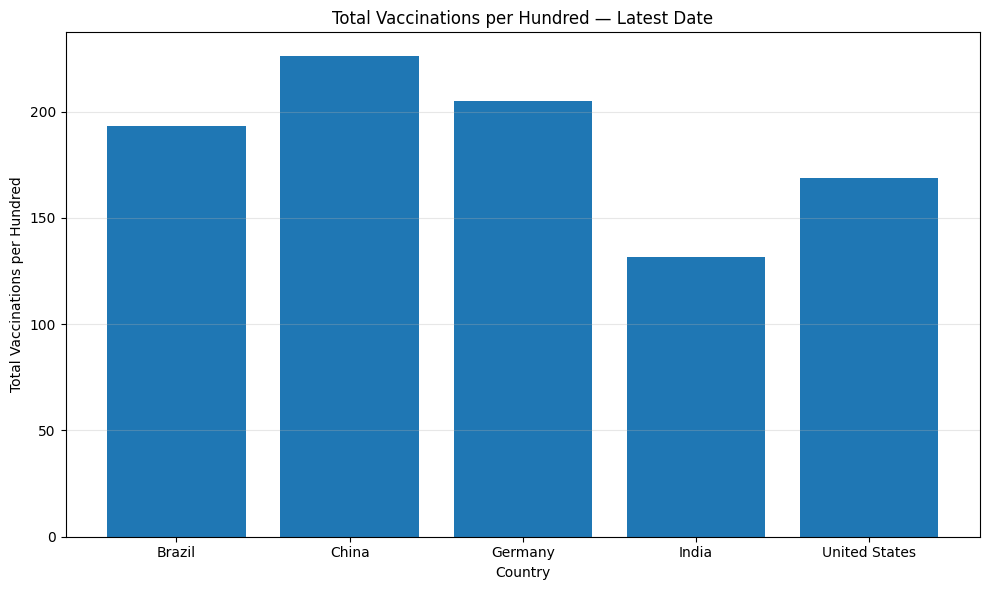

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(comp_plot["country"], comp_plot["total_vaccinations_per_hundred"])
plt.title("Total Vaccinations per Hundred — Latest Date")
plt.xlabel("Country")
plt.ylabel("Total Vaccinations per Hundred")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("per_hundred_comparison.png")
print("Saved: per_hundred_comparison.png")

In [17]:
leader = comp.sort_values("total_vaccinations_per_hundred", ascending=False).head(1)
print("\nLeader among the five (per hundred, latest date):")
print(leader)
print("-" * 50)


Leader among the five (per hundred, latest date):
      country  total_vaccinations_per_hundred
16225   China                          225.94
--------------------------------------------------


In [18]:
# 7) share_fully_vaccinated = people_fully_vaccinated / people_vaccinated (guard divide-by-zero)
df["share_fully_vaccinated"] = np.where(
    (df["people_vaccinated"] > 0) & (~df["people_fully_vaccinated"].isna()),
    df["people_fully_vaccinated"] / df["people_vaccinated"],
    np.nan
)

In [19]:
latest_share = df.loc[df.groupby("country")["date"].idxmax(), 
                      ["country", "people_vaccinated", "people_fully_vaccinated", "share_fully_vaccinated"]].copy()

top3_share = latest_share.sort_values("share_fully_vaccinated", ascending=False).head(3).reset_index(drop=True)
print("Top 3 countries by share_fully_vaccinated (latest date):")
print(top3_share)
print("\nInterpretation:")
print("- Higher share means a greater proportion of vaccinated people completed the full schedule,")
print("  indicating strong follow-through and/or emphasis on second doses/complete schedules.")
print("-" * 50)


Top 3 countries by share_fully_vaccinated (latest date):
    country  people_vaccinated  people_fully_vaccinated  \
0  Pitcairn               47.0                     47.0   
1   Tokelau              968.0                    968.0   
2      Togo          1558542.0                1557538.0   

   share_fully_vaccinated  
0                1.000000  
1                1.000000  
2                0.999356  

Interpretation:
- Higher share means a greater proportion of vaccinated people completed the full schedule,
  indicating strong follow-through and/or emphasis on second doses/complete schedules.
--------------------------------------------------


In [20]:
# 8) Unique vaccine combinations + top 3 (count ONCE per country using latest row)
vaccines_by_country = latest[["country", "vaccines"]].dropna()
unique_combos_count = vaccines_by_country["vaccines"].nunique()
print(f"Number of unique vaccine combinations: {unique_combos_count}")

print("\nTop 3 most common vaccine combinations (by country, latest row):")
print(vaccines_by_country["vaccines"].value_counts().head(3))
print("-" * 50)

Number of unique vaccine combinations: 84

Top 3 most common vaccine combinations (by country, latest row):
Oxford/AstraZeneca                                               20
Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    17
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                     15
Name: vaccines, dtype: int64
--------------------------------------------------


In [21]:
# 9) J&J countries — include Johnson & Johnson / Johnson&Johnson / Janssen variants
mask_jj = df["vaccines"].str.contains(
    r"Johnson\s*&\s*Johnson|Johnson&Johnson|Janssen", case=False, na=False, regex=True
)
jj = df[mask_jj].copy()

In [22]:
# Preferred pair; if either missing, auto-pick the top 2 J&J countries by number of records
preferred = ["South Africa", "Italy"]
if set(preferred).issubset(set(jj["country"].unique())):
    countries_to_compare = preferred
else:
    countries_to_compare = (
        jj.groupby("country").size().sort_values(ascending=False).head(2).index.tolist()
    )

print("Comparing J&J countries:", countries_to_compare)

Comparing J&J countries: ['South Africa', 'Italy']


Saved: jj_comparison.png


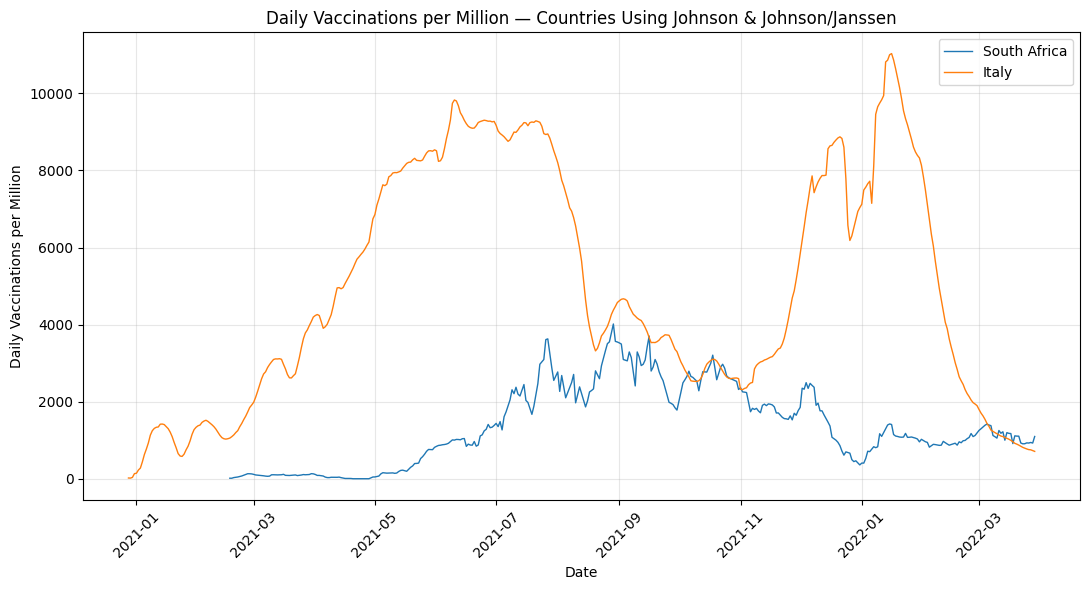

In [23]:
plt.figure(figsize=(11, 6))
for c in countries_to_compare:
    sub = jj[jj["country"] == c].sort_values("date")
    plt.plot(sub["date"], sub["daily_vaccinations_per_million"], label=c, linewidth=1)
plt.title("Daily Vaccinations per Million — Countries Using Johnson & Johnson/Janssen")
plt.xlabel("Date")
plt.ylabel("Daily Vaccinations per Million")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("jj_comparison.png")
print("Saved: jj_comparison.png")

In [24]:
# print latest available values for the plotted countries
jj_latest = jj.loc[jj.groupby("country")["date"].idxmax(), 
                   ["country", "date", "daily_vaccinations_per_million"]]
print("\nLatest Daily Vaccinations per Million — J&J Countries (for plotted countries):")
print(jj_latest[jj_latest["country"].isin(countries_to_compare)].reset_index(drop=True))
print("-" * 50)


Latest Daily Vaccinations per Million — J&J Countries (for plotted countries):
        country       date  daily_vaccinations_per_million
0         Italy 2022-03-29                           715.0
1  South Africa 2022-03-29                          1101.0
--------------------------------------------------
